In [1]:
from skimage import data, segmentation
from skimage import filters
from skimage import exposure
from skimage.morphology import skeletonize, skeletonize_3d
from skimage.util import invert
from skimage.measure import label, regionprops
from skimage.feature import match_template
from skimage import transform as tf
from skimage.exposure import rescale_intensity
from skimage.feature import (match_descriptors, corner_harris,
                             corner_peaks, ORB, plot_matches)

import matplotlib.pyplot as plt
import numpy as np
from functools import partial

import gym

In [2]:
def get_obses():
    obses = []
    env = gym.make('CarRacing-v0')
    for i_episode in range(2):
        observation = env.reset()
        for t in range(100):
            env.render()
            if t < 10:
                action = (1.1, 1, 0) # steer, gas, brake
            else:
                action = (0, 0, 0)
            observation, reward, done, info = env.step(action)
            gray_obs = np.mean(observation, axis=2)
            obses.append(gray_obs)
            if done:
                print("Episode finished after {} timesteps".format(t+1))
                break
    env.close()
    return obses

def find_road_and_car_from_sence(sence, show=False):
    "   "
    camera = sence
    hist, bins_center = exposure.histogram(camera)

    if show:
        plt.figure(figsize=(9, 4))
        plt.subplot(141)
        plt.imshow(camera, cmap='gray', interpolation='nearest')
        plt.axis('off')
        plt.subplot(142)

    road = np.bitwise_and(camera > 90, camera < 120)
    road = np.bitwise_or(road, camera < 2)
    road[-20:, :] = False
    # road[:10, :] = False # New
    car = np.bitwise_and(camera > 60, camera < 80)
    car[-10:, :] = False # New
    road = np.bitwise_or(road, car)

    if show:
        plt.imshow(road, cmap='gray', interpolation='nearest')
        plt.axis('off')
        plt.subplot(143)
        plt.imshow(car, cmap='gray', interpolation='nearest')
        plt.axis('off')
        plt.subplot(144)
        plt.plot(bins_center, hist, lw=2)
        plt.axvline(120, color='k', ls='--')

        plt.tight_layout()
        plt.show()
    
    return road, car

def find_skeleton(image, show=False):
    # perform skeletonization
    skeleton = skeletonize_3d(image)

    if show:
        # display results
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 4),
                                 sharex=True, sharey=True)

        ax = axes.ravel()

        ax[0].imshow(image, cmap=plt.cm.gray)
        #ax[0].axis('off')
        ax[0].set_title('original', fontsize=20)

        ax[1].imshow(skeleton, cmap=plt.cm.gray)
        #ax[1].axis('off')
        ax[1].set_title('skeleton', fontsize=20)

        fig.tight_layout()
        plt.show()
    
    return skeleton

def find_not_zero_from_matrix(m):
    ans = []
    for i, line in enumerate(m):
        for k, point in enumerate(line):
            if point>0:
                ans.append((i, k))
    return ans

In [3]:
obses = get_obses()

len(obses)

Track generation: 1104..1384 -> 280-tiles track
Track generation: 1189..1490 -> 301-tiles track


200

In [4]:
imshow = partial(plt.imshow, cmap='gray')

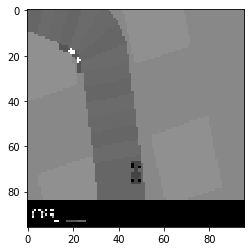

In [5]:
k = 99
imshow(obses[k])

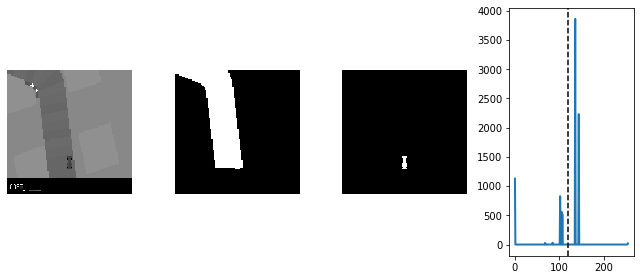

In [6]:
road, car = find_road_and_car_from_sence(obses[90], show=True)

In [7]:
road_skeleton = find_skeleton(road)
car_skeleton = find_skeleton(car)

In [8]:
road_xy = find_not_zero_from_matrix(road_skeleton)
car_xy = find_not_zero_from_matrix(car_skeleton)

In [9]:
car_head = car_xy[-1] # 预计稳定后一直是 (75, 47)  # 向下是x，向右是y
car_head

(75, 47)

In [10]:
road_xy = [a for a in road_xy if 60<a[0]<75]
road_xy

[(61, 39), (62, 39), (63, 40), (64, 40), (65, 40), (66, 40)]

In [11]:
car_bias = np.mean([y-47 for (x, y) in road_xy])

In [12]:
car_bias

-7.333333333333333

## The final ans: GET CAR BIAS

In [13]:
def cacl_car_bias(sence, show=False):
    road, car = find_road_and_car_from_sence(sence, show)
    road_skeleton = find_skeleton(road, show)
    car_skeleton = find_skeleton(car, show)
    road_xy = find_not_zero_from_matrix(road_skeleton)
    car_xy = find_not_zero_from_matrix(car_skeleton)
    car_head = car_xy[-1]
    road_xy = [a for a in road_xy if 60<a[0]<75]
    car_bias = np.mean([y-47 for (x, y) in road_xy])
    return car_bias

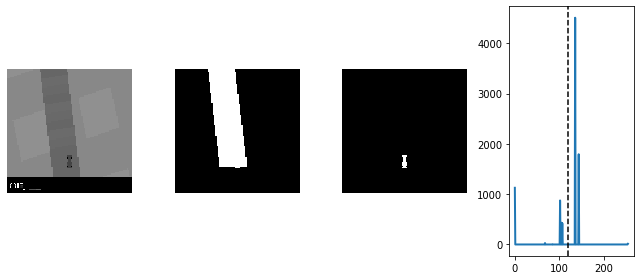

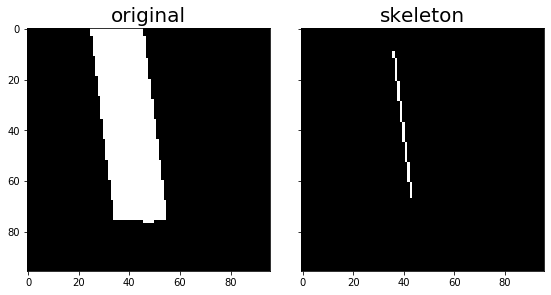

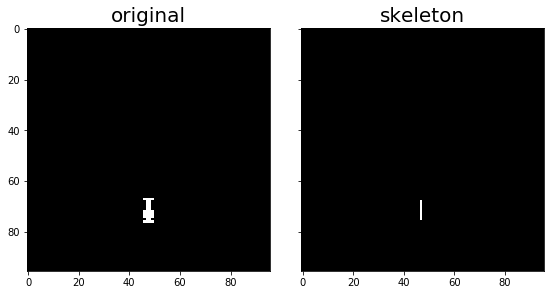

-4.0

In [14]:
cacl_car_bias(obses[50], show=True)  # 从50帧之后开始进行转弯控制

In [20]:
def test():
    obses = []
    env = gym.make('CarRacing-v0')
    for i_episode in range(2):
        observation = env.reset()
        gray_obs = np.mean(observation, axis=2)
        obses.append(gray_obs)
        for t in range(1000):
            env.render()
            if t < 10:
                action = (0, 1, 0) # steer, gas, brake
            elif 10 <=t < 50:
                action = (0, 0, 0)
            else:
                car_bias = cacl_car_bias(gray_obs)
                action = (car_bias/10, 0, 0)
            observation, reward, done, info = env.step(action)
            gray_obs = np.mean(observation, axis=2)
            obses.append(gray_obs)
            if done:
                print("Episode finished after {} timesteps".format(t+1))
                break
    env.close()
    return obses

_ = test()

Track generation: 1193..1497 -> 304-tiles track
Episode finished after 1000 timesteps
Track generation: 1243..1558 -> 315-tiles track
Episode finished after 1000 timesteps


## Find out the Car Use Tmpleta

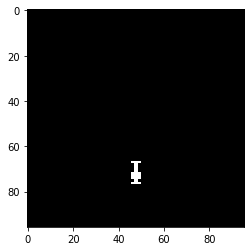

In [16]:
imshow(car)

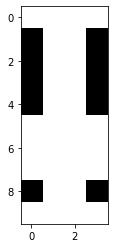

In [17]:
car_image = np.copy(car[67:77, 46:50]) 
imshow(car_image)

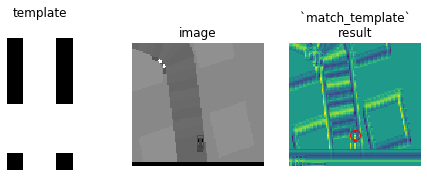

In [18]:
image = obses[90]
coin = car_image

result = match_template(image, coin)
ij = np.unravel_index(np.argmax(result), result.shape) # 图像中某些点转换成坐标
x, y = ij[::-1] # 注意这里的写法

fig = plt.figure(figsize=(8, 3))
ax1 = plt.subplot(1, 3, 1)
ax2 = plt.subplot(1, 3, 2)
ax3 = plt.subplot(1, 3, 3, sharex=ax2, sharey=ax2)

ax1.imshow(coin, cmap=plt.cm.gray)
ax1.set_axis_off()
ax1.set_title('template')

ax2.imshow(image, cmap=plt.cm.gray)
ax2.set_axis_off()
ax2.set_title('image')
# highlight matched region
hcoin, wcoin = coin.shape
rect = plt.Rectangle((x, y), wcoin, hcoin, edgecolor='r', facecolor='none')
ax2.add_patch(rect)

ax3.imshow(result)
ax3.set_axis_off()
ax3.set_title('`match_template`\nresult')
# highlight matched region
ax3.autoscale(False)
ax3.plot(x, y, 'o', markeredgecolor='r', markerfacecolor='none', markersize=10)

plt.show()

In [19]:
np.unravel_index??